
<img src= "https://nooksacktribe.org/wp-content/themes/nooksack-tribe-1-7/dist/assets/images/nooksack-tribe-logo-reverse.png"
style="float:left;width:175px;padding:10px">   
<br />
<br />
# Nooksack Forest Modeling

## Skookum Creek Case Study: Analyze downloaded gridded climate time-series data and generate a hybrid climate product

Use this Jupyter Notebook to: <br />
* Map gridded cell centroids,
* Download climate data, <br /> 
* Make dictionaries for watershed data, <br />
* Generate global bias correction factors from low elevations, <br />
* Generate local (1 to 1) bias correction factors for each grid cell, <br />
* Bias correct to monthly means at each grid cell.
* Bias correct to monthly means near observations (low elevations).
* Generate a hydrid climate product dictionary.  <br />
* Map results.  <br />
* Convert daily data to 3-hourly time series for Velma and DHSVM model inputs<br />
* Make data publicly accessible on HydroShare.  <br />
<img src= "https://www.engr.washington.edu/files/mycoe/marcom/cee/imgs/UW_CEE_purp_disp.jpg"
style="float:right;width:350px;padding:10px">  


## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libaries. These are listed in order of a) Python standard libraries, b) hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading and creation, and c) the observatory_gridded_hydromet library that is downloaded with this notebook. 

In [1]:
import os
import pandas as pd, numpy as np, dask, json
from utilities import hydroshare
%matplotlib inline
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
import copy
import ogh

In [2]:
hs=hydroshare.hydroshare()
homedir = hs.getContentPath('e47aabb406bc45a28f34b97a832daa08')

Successfully established a connection with HydroShare


In [3]:
notebookdir = os.getcwd()

hs=hydroshare.hydroshare()
#homedir = hs.getContentPath(os.environ["HS_RES_ID"])
os.chdir(homedir)
print('Data will be loaded from and save to:'+homedir)

Successfully established a connection with HydroShare
Data will be loaded from and save to:/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents


In [4]:
json.load(open('ogh_meta.json'))

{'dailywrf_salathe2014': {'domain': 'cses.washington.edu/',
  'end_date': '2010-12-31',
  'reference': {'1': 'Salathé Jr EP, Hamlet AF, Mass CF, Lee SY, Stumbaugh M, Steed R. Estimates of twenty-first-century flood risk in the Pacific Northwest based on regional climate model simulations. Journal of Hydrometeorology. 2014 Oct;15(5):1881-99. DOI: 10.1175/JHM-D-13-0137.1',
   '2': 'http://cses.washington.edu/rocinante/WRF/README'},
  'file_format': 'ASCII',
  'spatial_resolution': '1/16-degree',
  'variable_info': {'TMAX': {'units': 'C',
    'dtypes': 'float64',
    'desc': 'Maximum temperature at 2m'},
   'PRECIP': {'units': 'mm',
    'dtypes': 'float64',
    'desc': 'Daily accumulated precipitation'},
   'TMIN': {'units': 'C',
    'dtypes': 'float64',
    'desc': 'Minimum temperature at 2m'},
   'WINDSPD': {'units': 'm/s', 'dtypes': 'float64', 'desc': 'Wind Speed'}},
  'delimiter': '\\s+',
  'decision_steps': '',
  'temporal_resolution': 'D',
  'web_protocol': 'http',
  'subdomain': '/

In [5]:
# initialize ogh_meta
meta_file = dict(ogh.ogh_meta())
sorted(meta_file.keys())


['dailymet_bclivneh2013',
 'dailymet_livneh2013',
 'dailymet_livneh2013_wrfbc',
 'dailymet_livneh2013_wrfbc_global',
 'dailymet_livneh2015',
 'dailyvic_livneh2013',
 'dailyvic_livneh2015',
 'dailywrf_bcsalathe2014',
 'dailywrf_salathe2014']

In [6]:
# Livneh et al., 2013
dr1 = meta_file['dailymet_livneh2013']

# Salathe et al., 2014
dr2 = meta_file['dailywrf_salathe2014']

# define overlapping time window
dr = ogh.overlappingDates(date_set1=tuple([dr1['start_date'], dr1['end_date']]), 
                          date_set2=tuple([dr2['start_date'], dr2['end_date']]))
dr

('1950-01-01', '2010-12-31')

If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon to return to the File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

## 2. Get list of gridded climate points for the watershed

This example uses a shapefile with the watershed boundary of the SKookum Basin, which is stored in HydroShare at the following url: https://www.hydroshare.org/resource/23fcce3c57584468b06526285f1116f5/. 

The data for our processing routines can be retrieved using the getResourceFromHydroShare function by passing in the global identifier from the url above.  In the next cell, we download this resource from HydroShare, and identify that the points in this resource are available for downloading gridded hydrometeorology data, based on the point shapefile at https://www.hydroshare.org/resource/ef2d82bf960144b4bfb1bae6242bcc7f/, which is for the extent of North America and includes the average elevation for each 1/16 degree grid cell.  The file must include columns with station numbers, latitude, longitude, and elevation. The header of these columns must be FID, LAT, LONG_, and ELEV or RASTERVALU, respectively. The station numbers will be used for the remainder of the code to uniquely reference data from each climate station, as well as to identify minimum, maximum, and average elevation of all of the climate stations.  The webserice is currently set to a URL for the smallest geographic overlapping extent - e.g. WRF for Columbia River Basin (to use a limit using data from a FTP service, treatgeoself() would need to be edited in observatory_gridded_hydrometeorology utility). 

In [7]:
""""
1/16-degree Gridded cell centroids
"""
# List of available data
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
NAmer = hs.content['NAmer_dem_list.shp']

"""
Skookum (South Fork Nooksack)
"""
# Watershed extent
hs.getResourceFromHydroShare('ef2d82bf960144b4bfb1bae6242bcc7f')
skookum = hs.content['SkookumHUC171100040404.shp']


This resource already exists in your userspace.
ef2d82bf960144b4bfb1bae6242bcc7f/
|-- ef2d82bf960144b4bfb1bae6242bcc7f/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- NAmer_dem_list.cpg
|   |   |   |-- NAmer_dem_list.dbf
|   |   |   |-- NAmer_dem_list.prj
|   |   |   |-- NAmer_dem_list.sbn
|   |   |   |-- NAmer_dem_list.sbx
|   |   |   |-- NAmer_dem_list.shp
|   |   |   |-- NAmer_dem_list.shx
|   |   |   |-- NooksackHUC17110004.cpg
|   |   |   |-- NooksackHUC17110004.shp
|   |   |   |-- NooksackHUC17110004.shx
|   |   |   |-- SouthForkHUC1711000404.shp
|   |   |   |-- SouthForkHUC1711000404.shx
|   |   |   |-- NooksackHUC17110004.dbf
|   |   |   |-- NooksackHUC17110004.prj
|   |   |   |-- Observatory_nooksack_hybridbiascorrection_20190926.ipynb
|   |   |   |-- Observatory_skagit_hybridbiascorrection_20190315.ipynb
|   |   |   |-- OG

This resource already exists in your userspace.
ef2d82bf960144b4bfb1bae6242bcc7f/
|-- ef2d82bf960144b4bfb1bae6242bcc7f/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- NAmer_dem_list.cpg
|   |   |   |-- NAmer_dem_list.dbf
|   |   |   |-- NAmer_dem_list.prj
|   |   |   |-- NAmer_dem_list.sbn
|   |   |   |-- NAmer_dem_list.sbx
|   |   |   |-- NAmer_dem_list.shp
|   |   |   |-- NAmer_dem_list.shx
|   |   |   |-- NooksackHUC17110004.cpg
|   |   |   |-- NooksackHUC17110004.shp
|   |   |   |-- NooksackHUC17110004.shx
|   |   |   |-- SouthForkHUC1711000404.shp
|   |   |   |-- SouthForkHUC1711000404.shx
|   |   |   |-- NooksackHUC17110004.dbf
|   |   |   |-- NooksackHUC17110004.prj
|   |   |   |-- Observatory_nooksack_hybridbiascorrection_20190926.ipynb
|   |   |   |-- Observatory_skagit_hybridbiascorrection_20190315.ipynb
|   |   |   |-- OG

In [37]:
# Generate list of stations to download
mappingfile=ogh.treatgeoself(shapefile=skookum, NAmer=NAmer, buffer_distance=0.09, 
                              mappingfile=os.path.join(os.getcwd(),'skookum_mappingfile.csv'))
print(mappingfile)


(20, 4)
   FID       LAT      LONG_    ELEV
0    0  48.78125 -121.96875  1029.0
1    1  48.78125 -122.03125   740.0
2    2  48.78125 -122.09375   526.0
3    3  48.78125 -122.15625   403.0
4    4  48.71875 -121.90625  1061.0
/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/skookum_mappingfile.csv


## Commercial Break for Python lession on functions and Contributing to the Observatory

### In the next step, we want to select grid centroid of the lowest elevation grid cells
View the station locations in this [interactive Google map of the climate dataset grid centroids and Skookum watershed](https://www.google.com/maps/d/edit?mid=1MwvcMk2UvEO8K4NGTM_3jGzXGkxOL-81&ll=48.67006706749427%2C-122.2752676685605&z=10). 
#### We can do this by sorting and filtering the mappingfile by elevation, but how you select and apply a global correction to the atmospheric model grid to fit the monthly means at the low elevation stations, will likely vary by watershed and data availability and use of the model you are developing.   
In the next few steps, we explain how to manually explore the data table, select centroids, and create a new file to map only the low elevation centroids for further analysis. Choose your own adventure. 

**1) Manual investigation options:**  change the spatial count of grid cell centroids to include and change the name of the output file (csv).  

**2) Automate by Editing the OGH treatgeoself() function:**  rename the function, test that it works, check the output compared to the manual steps.

**Share and Contribute!!** 

Please share your new functions at https://github.com/ChristinaB/Observatory  (April-May 2020) and the main [Observatory](https://github.com/Freshwater-Initiative/Observatory) repository (after June 2020).  

#### 1) Manual investigation: How many grid cells in your spatial average of low elevation centroids?  

In [38]:
# How many grid cells in your spatial average of low elevation centroids?  
spatialcount=3   #this should be more than one station, but within less than 500 m elevation change to avoid -6 C/km lapse rate assumptions in temperature. 

#read mappingfile, it's a simple csv
all_centroids=pd.read_csv(mappingfile1)
#put into a Pandas dataframe
df_centroids=pd.DataFrame(all_centroids)
#print header plus a few rows to see the column names
df_centroids.head()
#sort by elevation
elev_sort_centroids=df_centroids.sort_values(by='ELEV')
#print header plus a few rows to see the low elevation values
elev_sort_centroids.head()
#save selection of low elevation points (we know these are near the Coop station at Acme)
print(elev_sort_centroids[:spatialcount])
elev_sort_centroids[:spatialcount].to_csv("mappinfile_3_lowelevation.csv")

    FID       LAT      LONG_   ELEV
15   15  48.65625 -122.21875  302.0
9     9  48.71875 -122.21875  318.0
8     8  48.71875 -122.15625  330.0


#### 2) Automate the function: How many grid cells in your spatial average of low elevation centroids?  

In [40]:

def treatgeoself_lowfilter(spatialcount,shapefile, NAmer, mappingfile=os.path.join(os.getcwd(), 'mappingfile.csv'), buffer_distance=0.06):
    """
    TreatGeoSelf to some [data] lovin'!
    shapefile: (dir) the path to an ESRI shapefile for the region of interest
    Namer: (dir) the path to the ESRI shapefile, which has each 1/16th-degree gridded cell centroid and DEM elevation
    mappingfile: (str) the name of the output file; default is 'mappingfile.csv'
    buffer_distance: (float64) the multiplier for increasing the geodetic boundary area; default is 0.06
    """
    # conform projections to longlat values in WGS84
    ogh.reprojShapefile(shapefile, newprojdictionary={'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}, outpath=None)

    # read shapefile into a multipolygon shape-object
    shape_mp = ogh.getFullShape(shapefile)

    # read in the North American continental DEM points for the station elevations
    NAmer_datapoints = ogh.readShapefileTable(NAmer).rename(columns={'Lat': 'LAT', 'Long': 'LONG_', 'Elev': 'ELEV'})

    # generate maptable
    maptable = ogh.filterPointsinShape(shape_mp,
                                   points_lat=NAmer_datapoints.LAT,
                                   points_lon=NAmer_datapoints.LONG_,
                                   points_elev=NAmer_datapoints.ELEV,
                                   buffer_distance=buffer_distance, buffer_resolution=16,
                                   labels=['LAT', 'LONG_', 'ELEV'])
    maptable.reset_index(inplace=True)
    maptable=maptable.sort_values(by='ELEV')
    maptable = maptable.rename(columns={'index': 'FID'})
    elev_filter_maptable = maptable[:spatialcount] 
    print(elev_filter_maptable.shape)
    print(elev_filter_maptable.head())

    # print the mappingfile
    elev_filter_maptable.to_csv(mappingfile, sep=',', header=True, index=False)
    return(mappingfile)

In [41]:
# Use the function to Generate list of stations to download
mappingfile_low=treatgeoself_lowfilter(spatialcount,shapefile=skookum, NAmer=NAmer, buffer_distance=0.09, 
                              mappingfile=os.path.join(os.getcwd(),'acme_low_3_elev_mappingfile.csv'))
print(mappingfile_low)

(3, 4)
    FID       LAT      LONG_   ELEV
15   15  48.65625 -122.21875  302.0
9     9  48.71875 -122.21875  318.0
8     8  48.71875 -122.15625  330.0
/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/acme_low_3_elev_mappingfile.csv


## End of Commercial Break

## Map the Gridded Cell Centroids that intersect with the watersheds of interest
### Summarize the file availability from each watershed mapping file

 ## 2. Download climate data 
 Get the daily data for a gridded observation dataset and an atmospheric model for **all grid cells** of interest. 

In [58]:
ogh.getDailyMET_livneh2013(homedir, mappingfile)
ogh.getDailyWRF_salathe2014(homedir, mappingfile)

Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-121.90625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.78125_-122.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.78125_-122.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.78125_-121.96875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.78125_-122.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-121.96875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.09375 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.21875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_-121.90625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_-121.96875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_-122.03125 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_-122.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_

'/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/salathe2014/WWA_1950_2010/raw'

Repeat for low elevation grid cells.

In [59]:
ogh.getDailyMET_livneh2013(homedir, mappingfile_low)
ogh.getDailyWRF_salathe2014(homedir, mappingfile_low)

Meteorology_Livneh_CONUSExt_v.1.2_2013_48.65625_-122.21875 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.15625 unzipped
Meteorology_Livneh_CONUSExt_v.1.2_2013_48.71875_-122.21875 unzipped
downloaded: data_48.71875_-122.15625
downloaded: data_48.71875_-122.21875
downloaded: data_48.65625_-122.21875


'/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/salathe2014/WWA_1950_2010/raw'

## 3. Put data in dictionaries by watershed


In [62]:
ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1])

ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile,
                               metadata=meta_file,
                               dataset='dailywrf_salathe2014',
                               file_start_date=dr2['start_date'], 
                               file_end_date=dr2['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_skook)

   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
Number of gridded data files:20
Minimum elevation: 302.0m
Mean elevation: 709.95m
Maximum elevatio

In [63]:
ltm_skook_low = ogh.gridclim_dict(mappingfile=mappingfile_low,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1])

ltm_skook_low = ogh.gridclim_dict(mappingfile=mappingfile_low,
                               metadata=meta_file,
                               dataset='dailywrf_salathe2014',
                               file_start_date=dr2['start_date'], 
                               file_end_date=dr2['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_skook_low)

   FID       LAT      LONG_   ELEV  \
0   15  48.65625 -122.21875  302.0   
1    9  48.71875 -122.21875  318.0   
2    8  48.71875 -122.15625  330.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
Number of gridded data files:3
Minimum elevation: 302.0m
Mean elevation: 316.6666666666667m
Maximum elevation: 330.0m
Number of data files within elevation range (302.0:330.0): 3
PRECIP dataframe reading to start: 0:00:00.008158
PRECIP dataframe complete:0:00:00.082543
TMAX dataframe reading to start: 0:00:00.088504
TMAX dataframe complete:0:00:00.148860
TMIN dataframe reading to start: 0:00:00.1546

In [71]:
#EXAMPLE of manual or shapefile based creation of the mappingfile
#low_shapefile = 'a file not created in this workshop.csv'
#3/3/2020 manually made mapping file for lowest point near Acme grid cell
#mappingfile_low=os.path.join(homedir,'skookum_acme_mappingfile.csv')
#print(mappingfile_low)
#dr[1]
#ogh.getDailyMET_livneh2013(homedir, mappingfile_low)
#ogh.getDailyWRF_salathe2014(homedir, mappingfile_low)
#ltm_low = ogh.gridclim_dict(mappingfile=mappingfile_low,
#                               metadata=meta_file,
#                               dataset='dailymet_livneh2013',
#                               file_start_date=dr1['start_date'], 
#                               file_end_date=dr1['end_date'],
#                               file_time_step=dr1['temporal_resolution'],
#                               subset_start_date=dr[0],
#                               subset_end_date=dr[1])

#ltm_low = ogh.gridclim_dict(mappingfile=mappingfile_low,
#                               metadata=meta_file,
#                               dataset='dailywrf_salathe2014',
#                               file_start_date=dr2['start_date'], 
#                               file_end_date=dr2['end_date'],
#                               file_time_step=dr1['temporal_resolution'],
#                               subset_start_date=dr[0],
#                               subset_end_date=dr[1],
#                               df_dict=ltm_low)

## 4. Local: 
### Generate dataframe of correction factors for each i,j grid cell

In [64]:
BiasCorr_wrfbc_skook = ogh.compute_diffs(df_dict=ltm_skook, df_str='skookum',
                                   gridclimname1='dailywrf_salathe2014',
                                   gridclimname2='dailymet_livneh2013',
                                   prefix2=['month'],
                                   prefix1=meta_file['dailymet_livneh2013']['variable_list'])

BiasCorr_wrfbc_skook_P = ogh.compute_ratios(df_dict=ltm_skook, df_str='skookum',
                                      gridclimname1='dailywrf_salathe2014',
                                      gridclimname2='dailymet_livneh2013',
                                      prefix2=['month'],
                                      prefix1=meta_file['dailymet_livneh2013']['variable_list'])

           
BiasCorr_wrfbc_skook['PRECIP_skookum'] = BiasCorr_wrfbc_skook_P['PRECIP_skookum']
ogh.saveDictOfDf('BiasCorr_wrfbc_skook.json', dictionaryObject=BiasCorr_wrfbc_skook)
BiasCorrTemplate=BiasCorr_wrfbc_skook #size of input grid cells

In [66]:
print(BiasCorr_wrfbc_skook['PRECIP_skookum'][0])
print(BiasCorr_wrfbc_skook_P['PRECIP_skookum'][0])

     48.78125
   -121.96875
1    1.555205
2    1.672712
3    1.884841
4    2.077512
5    1.629646
6    1.906496
7    1.994424
8    1.337161
9    1.239952
10   1.248857
11   1.809441
12   1.450829
     48.78125
   -121.96875
1    1.555205
2    1.672712
3    1.884841
4    2.077512
5    1.629646
6    1.906496
7    1.994424
8    1.337161
9    1.239952
10   1.248857
11   1.809441
12   1.450829


In [67]:

print(BiasCorr_wrfbc_skook)

print('WRF')
print(ltm_skook['month_PRECIP_dailywrf_salathe2014'][0])
print('Obs')
print(ltm_skook['month_PRECIP_dailymet_livneh2013'][0])
print('LivBCWRF = Local Correction Factor')

print(BiasCorr_wrfbc_skook)

{'PRECIP_skookum':            0          1          2          3          4          5   \
     48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
   -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
1    1.555205   1.312502   1.135985   1.202662   1.343859   1.170480   
2    1.672712   1.423598   1.271726   1.304109   1.525992   1.263092   
3    1.884841   1.609824   1.370005   1.380164   1.664649   1.469164   
4    2.077512   1.857882   1.652831   1.550220   2.055656   1.867245   
5    1.629646   1.964637   1.943215   1.688000   1.324599   1.452084   
6    1.906496   1.786993   1.638473   1.561718   1.774762   1.629132   
7    1.994424   1.687336   1.541184   1.323346   1.304764   1.445946   
8    1.337161   1.229111   1.165070   1.122198   1.321313   1.279604   
9    1.239952   1.109319   1.014277   1.027453   1.256846   1.081451   
10   1.248857   1.072364   0.962403   1.047684   1.189831   0.974402   
11   1.809441   1.514989   1.279813   1.23466

In [68]:
Daily_MET_1915_2011_WRFbc, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile1,
                                                           BiasCorr=BiasCorr_wrfbc_skook,
                                                           metadata=meta_file,
                                                           start_catalog_label='dailymet_livneh2013',
                                                           end_catalog_label='dailymet_livneh2013_wrfbc', 
                                                           file_start_date=None,
                                                           file_end_date=None,
                                                           data_dir=None,
                                                           dest_dir_suffix='biascorrWRF_liv')


   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...  
Number of gridded data files:20
Minimum elevation: 302.0m
Mean elevation: 709.95m
Maximum elevatio

## Add the bias corrected dataset to the dataframe 

In [69]:
ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013_wrfbc',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_skook)

   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                           dailymet_livneh2013_wrfbc  
0  /home/jovyan/work/notebooks/data/

In [70]:
print(ltm_skook['month_PRECIP_dailywrf_salathe2014'][9])#high elevation
print(ltm_skook['month_PRECIP_dailywrf_salathe2014'][0])#low elevation
print(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc'][9])#high elevation
print(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc'][0])#low elevation


     48.71875
   -122.21875
1    9.662200
2    7.986071
3    7.195098
4    5.923792
5    4.099577
6    3.832153
7    1.855494
8    2.022237
9    3.390574
10   6.801036
11   9.812344
12   9.630592
     48.78125
   -121.96875
1   16.246235
2   13.491062
3   11.649133
4    8.666093
5    5.989942
6    5.477842
7    2.818112
8    2.939492
9    4.751792
10  10.144897
11  15.690995
12  16.126103
     48.71875
   -122.21875
1    9.662200
2    7.986070
3    7.195097
4    5.923794
5    4.099577
6    3.832155
7    1.855494
8    2.022238
9    3.390574
10   6.801038
11   9.812346
12   9.630593
     48.78125
   -121.96875
1   16.246234
2   13.491062
3   11.649132
4    8.666093
5    5.989942
6    5.477841
7    2.818111
8    2.939492
9    4.751793
10  10.144894
11  15.690994
12  16.126103


## 5. Global: 

### Repeat steps above for Low Elevation Climate Correction

## Commercial Break - why use OGH?  because calculating all these statistics does not need to be reinvented 

Here is how you list all of the variables available because you used ogh.grid_clim_dict()

In [91]:
sorted(ltm_skook.keys())

['PRECIP_dailymet_livneh2013',
 'PRECIP_dailymet_livneh2013_wrfbc',
 'PRECIP_dailymet_livneh2013_wrfbc_global',
 'PRECIP_dailywrf_salathe2014',
 'TMAX_dailymet_livneh2013',
 'TMAX_dailymet_livneh2013_wrfbc',
 'TMAX_dailymet_livneh2013_wrfbc_global',
 'TMAX_dailywrf_salathe2014',
 'TMIN_dailymet_livneh2013',
 'TMIN_dailymet_livneh2013_wrfbc',
 'TMIN_dailymet_livneh2013_wrfbc_global',
 'TMIN_dailywrf_salathe2014',
 'WINDSPD_dailymet_livneh2013',
 'WINDSPD_dailymet_livneh2013_wrfbc',
 'WINDSPD_dailymet_livneh2013_wrfbc_global',
 'WINDSPD_dailywrf_salathe2014',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_PRECIP_dailymet_livneh2013_wrfbc',
 'anom_year_PRECIP_dailymet_livneh2013_wrfbc_global',
 'anom_year_PRECIP_dailywrf_salathe2014',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMAX_dailymet_livneh2013_wrfbc',
 'anom_year_TMAX_dailymet_livneh2013_wrfbc_global',
 'anom_year_TMAX_dailywrf_salathe2014',
 'anom_year_TMIN_dailymet_livneh2013',
 'anom_year_TMIN_dailymet_livneh2013_

## End of Commerical Break

### Generate low elevation global correction factors

In [72]:
global_biascorr_PRECIP=ltm_skook_low['meanmonth_PRECIP_dailymet_livneh2013']/ltm_skook_low['meanmonth_PRECIP_dailywrf_salathe2014']
#print(global_biascorr_PRECIP)

global_biascorr_TMAX=ltm_skook_low['meanmonth_TMAX_dailymet_livneh2013']-ltm_skook_low['meanmonth_TMAX_dailywrf_salathe2014']
#print(global_biascorr_TMAX)

global_biascorr_TMIN=ltm_skook_low['meanmonth_TMIN_dailymet_livneh2013']-ltm_skook_low['meanmonth_TMIN_dailywrf_salathe2014']
#print(global_biascorr_TMIN)

global_wind=[0,0,0,0,0,0,0,0,0,0,0,0]

In [73]:
#Apply the monthly low elevation correction to every grid cell uniformly
#Initialize dictionary
Global_BiasCorr_wrfbc_skook=copy.deepcopy(BiasCorr_wrfbc_skook)

In [74]:
print(global_biascorr_PRECIP)
print(Global_BiasCorr_wrfbc_skook['PRECIP_skookum'][9])

1     0.676824
2     0.653304
3     0.620239
4     0.590418
5     0.623284
6     0.602805
7     0.777815
8     0.825558
9     0.824951
10    0.779727
11    0.713355
12    0.718987
dtype: float64
     48.71875
   -122.21875
1    1.422228
2    1.485071
3    1.566470
4    1.641250
5    1.555437
6    1.583767
7    1.232629
8    1.165087
9    1.157138
10   1.230174
11   1.353011
12   1.338354


In [75]:
for column in Global_BiasCorr_wrfbc_skook['PRECIP_skookum']:
   
    Global_BiasCorr_wrfbc_skook['PRECIP_skookum'].ix[1:12,column]=global_biascorr_PRECIP
    Global_BiasCorr_wrfbc_skook['TMAX_skookum'].ix[1:12,column]=global_biascorr_TMAX
    Global_BiasCorr_wrfbc_skook['TMIN_skookum'].ix[1:12,column]=global_biascorr_TMIN
    Global_BiasCorr_wrfbc_skook['WINDSPD_skookum'].ix[1:12,column]=global_wind
    
ogh.saveDictOfDf('Global_BiasCorr_wrfbc_skookum.json', dictionaryObject=Global_BiasCorr_wrfbc_skook)

In [26]:
#Global_BiasCorr_wrfbc_skook['PRECIP_skookum'][0]

## Bias correct LivnehWRFbc to low elevation bias correction 
#### Input: Correction array of 12 values, one per month for low elevation WRF bias, Livneh Time Series corrected to WRF
#### Output: Corrected Livneh data (livneh2013_wrfbc_global)

In [76]:
Global_BiasCorr_wrfbc_skook

{'PRECIP_skookum':            0          1          2          3          4          5   \
      48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
    -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
 1    0.676824   0.676824   0.676824   0.676824   0.676824   0.676824   
 2    0.653304   0.653304   0.653304   0.653304   0.653304   0.653304   
 3    0.620239   0.620239   0.620239   0.620239   0.620239   0.620239   
 4    0.590418   0.590418   0.590418   0.590418   0.590418   0.590418   
 5    0.623284   0.623284   0.623284   0.623284   0.623284   0.623284   
 6    0.602805   0.602805   0.602805   0.602805   0.602805   0.602805   
 7    0.777815   0.777815   0.777815   0.777815   0.777815   0.777815   
 8    0.825558   0.825558   0.825558   0.825558   0.825558   0.825558   
 9    0.824951   0.824951   0.824951   0.824951   0.824951   0.824951   
 10   0.779727   0.779727   0.779727   0.779727   0.779727   0.779727   
 11   0.713355   0.713355   0.713

In [77]:
Daily_MET_1915_2011_WRFbc_global, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile1,
                                                           BiasCorr=Global_BiasCorr_wrfbc_skook,
                                                           metadata=meta_file,
                                                           start_catalog_label='dailymet_livneh2013_wrfbc',
                                                           end_catalog_label='dailymet_livneh2013_wrfbc_global', 
                                                           file_start_date=None,
                                                           file_end_date=None,
                                                           data_dir=None,
                                                           dest_dir_suffix='biascorr_WRF_liv_global')

   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                           dailymet_livneh2013_wrfbc  
0  /home/jovyan/work/notebooks/data/

In [29]:
Daily_MET_1915_2011_WRFbc_global

'/home/jovyan/work/notebooks/data/e47aabb406bc45a28f34b97a832daa08/e47aabb406bc45a28f34b97a832daa08/data/contents/biascorr_WRF_liv_global'

### Add global corrected results to dictionary

In [78]:
ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset='dailymet_livneh2013_wrfbc_global',
                               file_start_date=dr1['start_date'], 
                               file_end_date=dr1['end_date'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_skook)

   FID       LAT      LONG_    ELEV  \
0    0  48.78125 -121.96875  1029.0   
1    1  48.78125 -122.03125   740.0   
2    2  48.78125 -122.09375   526.0   
3    3  48.78125 -122.15625   403.0   
4    4  48.71875 -121.90625  1061.0   

                                 dailymet_livneh2013  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                                dailywrf_salathe2014  \
0  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
1  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
2  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
3  /home/jovyan/work/notebooks/data/e47aabb406bc4...   
4  /home/jovyan/work/notebooks/data/e47aabb406bc4...   

                           dailymet_livneh2013_wrfbc  \
0  /home/jovyan/work/notebooks/data

### Check bias correction results

In [79]:
print(ltm_skook['month_PRECIP_dailywrf_salathe2014'][9])#high elevation
print(ltm_skook['month_PRECIP_dailywrf_salathe2014'][0])#low elevation
print(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc'][9])#high elevation
print(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc'][0])#low elevation
print(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc_global'][9])#high elevation
print(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc_global'][0])#low elevation


     48.71875
   -122.21875
1    9.662200
2    7.986071
3    7.195098
4    5.923792
5    4.099577
6    3.832153
7    1.855494
8    2.022237
9    3.390574
10   6.801036
11   9.812344
12   9.630592
     48.78125
   -121.96875
1   16.246235
2   13.491062
3   11.649133
4    8.666093
5    5.989942
6    5.477842
7    2.818112
8    2.939492
9    4.751792
10  10.144897
11  15.690995
12  16.126103
     48.71875
   -122.21875
1    9.662200
2    7.986070
3    7.195097
4    5.923794
5    4.099577
6    3.832155
7    1.855494
8    2.022238
9    3.390574
10   6.801038
11   9.812346
12   9.630593
     48.78125
   -121.96875
1   16.246234
2   13.491062
3   11.649132
4    8.666093
5    5.989942
6    5.477841
7    2.818111
8    2.939492
9    4.751793
10  10.144894
11  15.690994
12  16.126103
     48.71875
   -122.21875
1    6.539611
2    5.217334
3    4.462681
4    3.497517
5    2.555198
6    2.310042
7    1.443232
8    1.669473
9    2.797058
10   5.302952
11   6.999690
12   6.924275
     48.78125
   -12

## 6.  Compare Corrected Historic Hydrometeorology 

This section performs computations and generates plots of the Livneh 2013, Livneh 2016, and WRF 2014 temperature and precipitation data in order to compare them with each other and observations. The generated plots are automatically downloaded and saved as .png files in the "plots" folder of the user's home directory and inline in the notebook.

In [80]:
Global_BiasCorr_wrfbc_skook

{'PRECIP_skookum':            0          1          2          3          4          5   \
      48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
    -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
 1    0.676824   0.676824   0.676824   0.676824   0.676824   0.676824   
 2    0.653304   0.653304   0.653304   0.653304   0.653304   0.653304   
 3    0.620239   0.620239   0.620239   0.620239   0.620239   0.620239   
 4    0.590418   0.590418   0.590418   0.590418   0.590418   0.590418   
 5    0.623284   0.623284   0.623284   0.623284   0.623284   0.623284   
 6    0.602805   0.602805   0.602805   0.602805   0.602805   0.602805   
 7    0.777815   0.777815   0.777815   0.777815   0.777815   0.777815   
 8    0.825558   0.825558   0.825558   0.825558   0.825558   0.825558   
 9    0.824951   0.824951   0.824951   0.824951   0.824951   0.824951   
 10   0.779727   0.779727   0.779727   0.779727   0.779727   0.779727   
 11   0.713355   0.713355   0.713

In [81]:
BiasCorr_wrfbc_skook

{'PRECIP_skookum':            0          1          2          3          4          5   \
      48.78125   48.78125   48.78125   48.78125   48.71875   48.71875   
    -121.96875 -122.03125 -122.09375 -122.15625 -121.90625 -121.96875   
 1    1.555205   1.312502   1.135985   1.202662   1.343859   1.170480   
 2    1.672712   1.423598   1.271726   1.304109   1.525992   1.263092   
 3    1.884841   1.609824   1.370005   1.380164   1.664649   1.469164   
 4    2.077512   1.857882   1.652831   1.550220   2.055656   1.867245   
 5    1.629646   1.964637   1.943215   1.688000   1.324599   1.452084   
 6    1.906496   1.786993   1.638473   1.561718   1.774762   1.629132   
 7    1.994424   1.687336   1.541184   1.323346   1.304764   1.445946   
 8    1.337161   1.229111   1.165070   1.122198   1.321313   1.279604   
 9    1.239952   1.109319   1.014277   1.027453   1.256846   1.081451   
 10   1.248857   1.072364   0.962403   1.047684   1.189831   0.974402   
 11   1.809441   1.514989   1.279

In [82]:
print('WRF')
print(ltm_skook['month_TMAX_dailywrf_salathe2014'][0])
print('Obs')
print(ltm_skook['month_TMAX_dailymet_livneh2013'][0])
print('LivBCWRF = Local Correction Factor')
print(BiasCorr_wrfbc_skook ['TMAX_skookum'][0])
print('LivBCWRF result')
print(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc'][0])
print('WRF bc Livneh Low Elev = Global  Correction Factor')
print(Global_BiasCorr_wrfbc_skook['TMAX_skookum'][0])
print('LivBCWRF+ WRFbcLivLow= Local+Global result')
print(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc_global'][0])
print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')


WRF
     48.78125
   -121.96875
1   -0.907737
2   -0.128787
3    0.505944
4    2.991481
5    7.008080
6   10.701858
7   14.471835
8   14.930497
9   13.090087
10   8.122808
11   2.604350
12  -0.101475
Obs
     48.78125
   -121.96875
1   -1.297938
2    1.719106
3    4.495383
4    8.532109
5   12.366113
6   14.993918
7   18.437509
8   18.420984
9   15.110672
10   8.872782
11   2.502825
12  -0.889085
LivBCWRF = Local Correction Factor
     48.78125
   -121.96875
1    0.390201
2   -1.847893
3   -3.989439
4   -5.540628
5   -5.358033
6   -4.292060
7   -3.965674
8   -3.490487
9   -2.020585
10  -0.749974
11   0.101525
12   0.787610
LivBCWRF result
     48.78125
   -121.96875
1   -0.907738
2   -0.128794
3    0.505983
4    2.991509
5    7.008113
6   10.701818
7   14.471809
8   14.930484
9   13.090072
10   8.122782
11   2.604325
12  -0.101485
WRF bc Livneh Low Elev = Global  Correction Factor
     48.78125
   -121.96875
1    1.356191
2    2.278853
3    3.037828
4    2.995237
5    2.814513
6    2.9

In [ ]:
meta_file

In [84]:
%matplotlib inline

import matplotlib.pyplot as plt

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

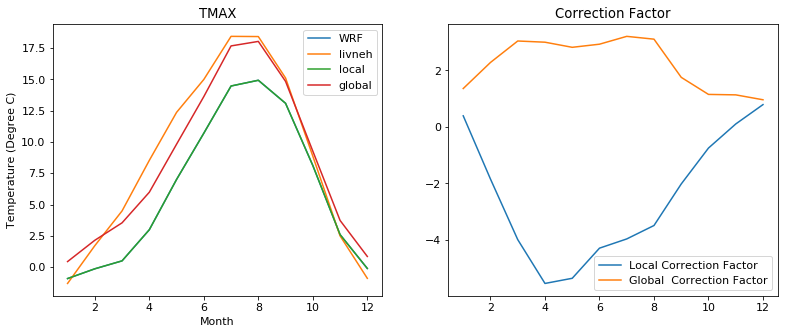

In [85]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 11}) 

plt.subplot(1,2,1)
plt.title('TMAX')
plt.plot(ltm_skook['month_TMAX_dailywrf_salathe2014'][0])
plt.plot(ltm_skook['month_TMAX_dailymet_livneh2013'][0])
plt.plot(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc'][0])
plt.plot(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc_global'][0])
plt.legend(['WRF', 'livneh','local','global'])
plt.xlabel('Month')
plt.ylabel('Temperature (Degree C)')
#plt.legend()

plt.subplot(1,2,2)
plt.title('Correction Factor')
plt.plot(BiasCorr_wrfbc_skook['TMAX_skookum'][0])
plt.plot(Global_BiasCorr_wrfbc_skook['TMAX_skookum'][0])
plt.legend(['Local Correction Factor','Global  Correction Factor'])
#print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')
plt.savefig('./monthly_bc_tmax.png',dpi=400)

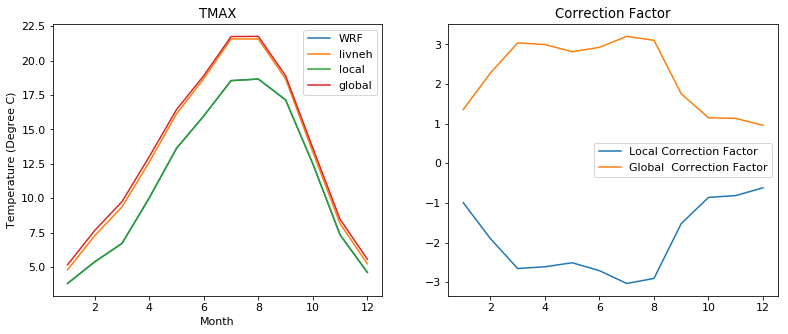

In [86]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 11}) 

plt.subplot(1,2,1)
plt.title('TMAX')
plt.plot(ltm_skook['month_TMAX_dailywrf_salathe2014'][9])
plt.plot(ltm_skook['month_TMAX_dailymet_livneh2013'][9])
plt.plot(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc'][9])
plt.plot(ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc_global'][9])
plt.legend(['WRF', 'livneh','local','global'])
plt.xlabel('Month')
plt.ylabel('Temperature (Degree C)')
#plt.legend()

plt.subplot(1,2,2)
plt.title('Correction Factor')
plt.plot(BiasCorr_wrfbc_skook['TMAX_skookum'][9])
plt.plot(Global_BiasCorr_wrfbc_skook['TMAX_skookum'][9])
plt.legend(['Local Correction Factor','Global  Correction Factor'])
#print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')
plt.savefig('./monthly_bc_tmax.png',dpi=400)

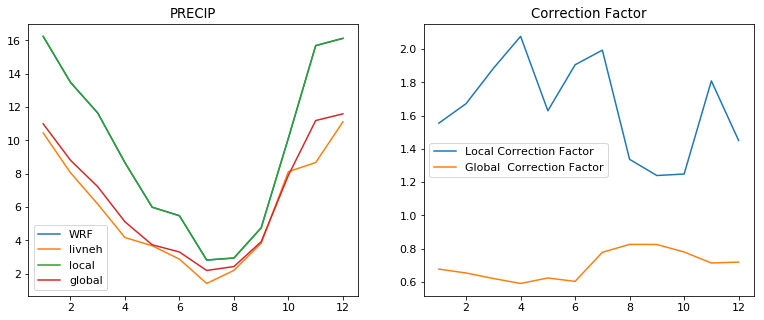

In [87]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 11}) 

plt.subplot(1,2,1)
plt.title('PRECIP')
plt.plot(ltm_skook['month_PRECIP_dailywrf_salathe2014'][0])
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013'][0])
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc'][0])
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc_global'][0])
plt.legend(['WRF', 'livneh','local','global'])
#plt.legend()

plt.subplot(1,2,2)
plt.title('Correction Factor')
plt.plot(BiasCorr_wrfbc_skook['PRECIP_skookum'][0])
plt.plot(Global_BiasCorr_wrfbc_skook['PRECIP_skookum'][0])
plt.legend(['Local Correction Factor','Global  Correction Factor'])
#print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')
plt.savefig('./monthly_bc_precip.png',dpi=400)

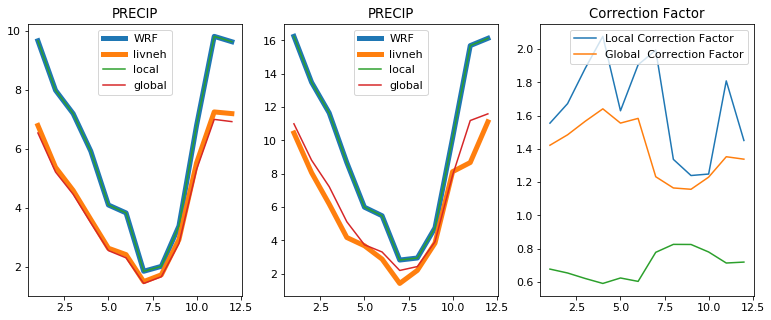

In [88]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 11}) 

plt.subplot(1,3,1)
plt.title('PRECIP')
plt.plot(ltm_skook['month_PRECIP_dailywrf_salathe2014'][9], linewidth=5)
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013'][9], linewidth=5)
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc'][9])
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc_global'][9])
plt.legend(['WRF', 'livneh','local','global'])

#plt.legend()
plt.subplot(1,3,2)
plt.title('PRECIP')
plt.plot(ltm_skook['month_PRECIP_dailywrf_salathe2014'][0], linewidth=5)
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013'][0], linewidth=5)
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc'][0])
plt.plot(ltm_skook['month_PRECIP_dailymet_livneh2013_wrfbc_global'][0])
plt.legend(['WRF', 'livneh','local','global'])
#plt.legend()



plt.subplot(1,3,3)
plt.title('Correction Factor')
plt.plot(BiasCorr_wrfbc_skook['PRECIP_skookum'][0])
plt.plot(BiasCorr_wrfbc_skook['PRECIP_skookum'][9])
plt.plot(Global_BiasCorr_wrfbc_skook['PRECIP_skookum'][9])
plt.legend(['Local Correction Factor','Global  Correction Factor'])
#print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')
plt.savefig('./monthly_bc_precip.png',dpi=400)

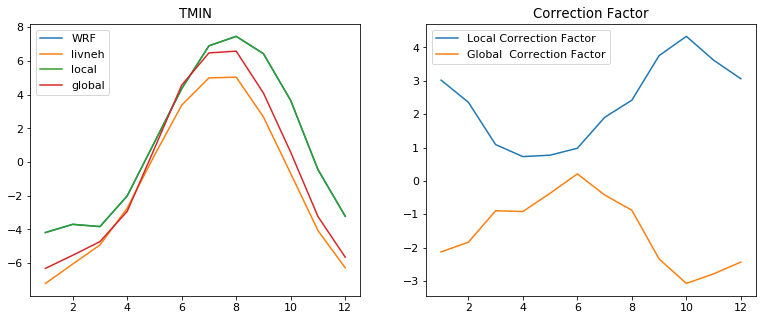

In [89]:
plt.figure(figsize=(13,5))
plt.rcParams.update({'font.size': 11}) 

plt.subplot(1,2,1)
plt.title('TMIN')
plt.plot(ltm_skook['month_TMIN_dailywrf_salathe2014'][0])
plt.plot(ltm_skook['month_TMIN_dailymet_livneh2013'][0])
plt.plot(ltm_skook['month_TMIN_dailymet_livneh2013_wrfbc'][0])
plt.plot(ltm_skook['month_TMIN_dailymet_livneh2013_wrfbc_global'][0])
plt.legend(['WRF', 'livneh','local','global'])
#plt.legend()

plt.subplot(1,2,2)
plt.title('Correction Factor')
plt.plot(BiasCorr_wrfbc_skook['TMIN_skookum'][0])
plt.plot(Global_BiasCorr_wrfbc_skook['TMIN_skookum'][0])
plt.legend(['Local Correction Factor','Global  Correction Factor'])
#print('Precipitation values are a ratio of WRF_m/Liv_m and Temperature values are the difference between WRF_m-Liv_m')
plt.savefig('./monthly_bc_tmin.png',dpi=400)

In [90]:
sorted(ltm_skook.keys())

['PRECIP_dailymet_livneh2013',
 'PRECIP_dailymet_livneh2013_wrfbc',
 'PRECIP_dailymet_livneh2013_wrfbc_global',
 'PRECIP_dailywrf_salathe2014',
 'TMAX_dailymet_livneh2013',
 'TMAX_dailymet_livneh2013_wrfbc',
 'TMAX_dailymet_livneh2013_wrfbc_global',
 'TMAX_dailywrf_salathe2014',
 'TMIN_dailymet_livneh2013',
 'TMIN_dailymet_livneh2013_wrfbc',
 'TMIN_dailymet_livneh2013_wrfbc_global',
 'TMIN_dailywrf_salathe2014',
 'WINDSPD_dailymet_livneh2013',
 'WINDSPD_dailymet_livneh2013_wrfbc',
 'WINDSPD_dailymet_livneh2013_wrfbc_global',
 'WINDSPD_dailywrf_salathe2014',
 'anom_year_PRECIP_dailymet_livneh2013',
 'anom_year_PRECIP_dailymet_livneh2013_wrfbc',
 'anom_year_PRECIP_dailymet_livneh2013_wrfbc_global',
 'anom_year_PRECIP_dailywrf_salathe2014',
 'anom_year_TMAX_dailymet_livneh2013',
 'anom_year_TMAX_dailymet_livneh2013_wrfbc',
 'anom_year_TMAX_dailymet_livneh2013_wrfbc_global',
 'anom_year_TMAX_dailywrf_salathe2014',
 'anom_year_TMIN_dailymet_livneh2013',
 'anom_year_TMIN_dailymet_livneh2013_

##### Print Maximum Annual Preciptation for different products and locations


In [38]:
print(ltm_skook['meanyear_PRECIP_dailymet_livneh2013'].max(axis=0))
print(ltm_skook['meanyear_PRECIP_dailywrf_salathe2014'].max(axis=0))


8.834777400547946
10.526569863013702


## Save to hydroshare

In [ ]:
from hs_restclient import HydroShare
hs = HydroShare()
hs_up = hydroshare.hydroshare()
notebook_file = './OGH_skookum_hybrid_20200302.ipynb'

In [ ]:
# write meta data such as abstract, title, keywords, resource type
#abstract = 'Notebook for Puyallup Bias-correction'
##title = 'Jupyter notebook Puyallup BC'
#keywords = ('OGH', 'Puyallup', 'notebook') # currently you need to include at least two keywords or the upload will fail
#resource_type = 'genericresource'
#files = notebook_file, # yes, you do need the comma after the file here. It's a python thing (tuple)


## 7. Apply Hybrid Bias to Future Data (Livneh2013MACA)

In [ ]:
#maptable.columns[8:]
maptable['bcc-csm1-1-m__rcp45']

In [ ]:
meta_MACA_file['CSIRO-Mk3-6-0__rcp45']['date_range']['start']

In [ ]:
for eachcol in maptable.columns[8:]:
    #if eachcol == 'bcc-csm1-1-m__rcp45'
    start_catalog_label1=eachcol
    end_catalog_label1=eachcol+'_wrfbc'
    dest_dir1=eachcol+'_wrfbc'
    Daily_MET_1915_2011_WRFbc, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile1,
                                                           BiasCorr=BiasCorr_wrfbc_skook,
                                                           metadata=meta_MACA_file,
                                                           start_catalog_label=start_catalog_label1,
                                                           end_catalog_label=end_catalog_label1, 
                                                           file_start_date=meta_MACA_file[start_catalog_label1]['date_range']['start'],
                                                           file_end_date=meta_MACA_file[start_catalog_label1]['date_range']['end'],
                                                           data_dir=None,
                                                           dest_dir_suffix=dest_dir1)
    start_catalog_label2=end_catalog_label1
    end_catalog_label2=eachcol+'_wrfbc_global'
    dest_dir2=eachcol+'_wrfbc_global'
    Daily_MET_1915_2011_WRFbc_global, meta_file = ogh.makebelieve(homedir=homedir,
                                                           mappingfile=mappingfile1,
                                                           BiasCorr=Global_BiasCorr_wrfbc_skook,
                                                           metadata=meta_MACA_file,
                                                           start_catalog_label=start_catalog_label2,
                                                           end_catalog_label=end_catalog_label2, 
                                                           file_start_date=meta_MACA_file[start_catalog_label2]['date_range']['start'],
                                                           file_end_date=meta_MACA_file[start_catalog_label2]['date_range']['end'],
                                                           data_dir=None,
                                                           dest_dir_suffix=dest_dir2)

In [ ]:
for each2map in ['IPSL-CM5A-MR__rcp45','IPSL-CM5A-MR__rcp45_wrfbc','IPSL-CM5A-MR__rcp45_wrfbc_global']:
    ltm_skook = ogh.gridclim_dict(mappingfile=mappingfile1,
                               metadata=meta_file,
                               dataset=each2map,
                               file_start_date=meta_MACA_file[start_catalog_label2]['date_range']['start'],
                               file_end_date=meta_MACA_file[start_catalog_label2]['date_range']['end'],
                               file_time_step=dr1['temporal_resolution'],
                               subset_start_date=dr[0],
                               subset_end_date=dr[1],
                               df_dict=ltm_skook)

## 8.  Compare Corrected Future Hydrometeorology to Historic percent correction

## 9.  Make Beautiful Maps 

In [ ]:
# graphical control libraries
import matplotlib as mpl
# mpl.use('agg')
import matplotlib.pyplot as plt


# shape and layer libraries
import fiona
import shapely.ops
from shapely.geometry import MultiPolygon, shape, point, box
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

def renderValuesInPoints_scale(vardf, vardf_dateindex, vardfmin, vardfmax, shapefile, outfilepath, plottitle, colorbar_label,
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='Canvas/World_Dark_Gray_Base', cmap='coolwarm'):
    """
    A function to render the dynamics across gridded cell centroids on the spatial landscape
    
    vardf: (dataframe) a time-series dataframe for a variable with time-points (rows) and gridded cell centroids (column)
    vardf_dateindex: (datetime or float) a datetime identifier to extract a row of data for visualization
    shapefile: (dir) the path to a shapefile
    outfilepath: (dir) the path for the output image file
    plottitle: (str) the title of the plot
    colorbar_label: (str) the label for the colorbar
    spatial_resolution: (float) the degree of longitude-latitude separation between gridded cell centroids, e.g., 1/16
    margin: (float) the fraction of width and height to view outside of the watershed shapefile
    epsg: (int) the epsg code for regional projection, e.g. 3857
    basemap_image: (str) the basemap arcgis service e.g., 'Canvas/World_Dark_Gray_Base' or 'ESRI_Imagery_World_2D'
    cmap: (str) the code for matplotlib colormaps, e.g. 'coolwarm',
    """
    
    # generate the figure axis
    fig = plt.figure(figsize=(2,2), dpi=500)
    ax1 = plt.subplot2grid((1,1),(0,0))

    # generate the polygon color-scheme
    cmap = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vardfmin, vardfmax)
    color_producer = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    # calculate bounding box based on the watershed shapefile
    watershed = fiona.open(shapefile)
    minx, miny, maxx, maxy = watershed.bounds
    w, h = maxx - minx, maxy - miny
    watershed.close()
    
    # generate basemap
    m = Basemap(projection='merc', epsg=epsg, resolution='h', ax=ax1,
                llcrnrlon=minx-margin*w, llcrnrlat=miny-margin*h, urcrnrlon=maxx+margin*w, urcrnrlat=maxy+margin*h)
    m.arcgisimage(service=basemap_image, xpixels=500)
                         
    # watershed
    m.readshapefile(shapefile=shapefile.replace('.shp',''), name='watershed', drawbounds=True, color='k')
    
    # variable dataframe
    midpt=spatial_resolution/2
    crs={'init':'epsg:{0}'.format(epsg)}
    cat=vardf.T.reset_index(level=[1,2]).rename(columns={'level_1':'LAT','level_2':'LONG_'})
    geometry = cat.apply(lambda x: 
                         shapely.ops.transform(m, box(x['LONG_']-midpt, x['LAT']-midpt, 
                                                      x['LONG_']+midpt, x['LAT']+midpt)), axis=1)
    cat = gpd.GeoDataFrame(cat, crs=crs, geometry=geometry).reset_index(drop=True)

    # geopandas print
    cat.plot(column=vardf_dateindex, cmap=cmap, alpha=0.4, ax=ax1,
             vmin=vardfmin, vmax=vardfmax)

    # assimilate the shapes to plot
    patches = []
    for ind, eachpol in cat.iterrows():
        patches.append(PolygonPatch(eachpol['geometry'], linewidth=0, zorder=5.0,
                                    fc=color_producer.to_rgba(eachpol[vardf_dateindex])))

    # assimilate shapes into a patch collection
    coll = PatchCollection(patches, cmap=cmap, match_original=True, zorder=10.0)
    
    # generate colorbar
    coll.set_array(vardf.values.flatten())
    coll.set_clim([vardfmin, vardfmax])
    cbar = plt.colorbar(coll, shrink=0.5)
    cbar.ax.set_ylabel(colorbar_label, rotation=270, size=3, labelpad=5) # colorbar label
    cbar.ax.tick_params(labelsize=3) # colorbar tick fontsize

    # save image
    plt.title(plottitle, fontsize=3)
    plt.savefig(outfilepath)
    plt.show()

In [ ]:
def renderValuesInPoints(vardf, vardf_dateindex, shapefile, outfilepath, plottitle, colorbar_label,
                         vmin=None, vmax=None, spatial_resolution=1/16, margin=0.5, gridcell_alpha=0.5, epsg=3857,
                         basemap_image='Canvas/World_Dark_Gray_Base', cmap='coolwarm', figsize=(2, 2)):
    """
    A function to render the dynamics across gridded cell centroids on the spatial landscape
    vardf: (dataframe) a time-series dataframe for a variable with time-points (rows) and gridded cell centroids (column)
    vardf_dateindex: (datetime or float) a datetime identifier to extract a row of data for visualization
    shapefile: (dir) the path to a shapefile
    outfilepath: (dir) the path for the output image file
    plottitle: (str) the title of the plot
    colorbar_label: (str) the label for the colorbar
    spatial_resolution: (float) the degree of longitude-latitude separation between gridded cell centroids, e.g., 1/16
    margin: (float) the fraction of width and height to view outside of the watershed shapefile
    epsg: (int) the epsg code for regional projection, e.g. 3857
    basemap_image: (str) the basemap arcgis service e.g., 'Canvas/World_Dark_Gray_Base' or 'ESRI_Imagery_World_2D'
    cmap: (str) the code for matplotlib colormaps, e.g. 'coolwarm',
    """
    # generate the figure axis
    fig = plt.figure(figsize=figsize, dpi=500)
    ax1 = plt.subplot2grid((1, 1), (0, 0))

    # set params
    if isinstance(vmin, type(None)):
        vmin = vardf.values.flatten().min()

    if isinstance(vmax, type(None)):
        vmax = vardf.values.flatten().max()

    # generate the polygon color-scheme
    cmap = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin, vmax)
    color_producer = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    # calculate bounding box based on the watershed shapefile
    watershed = fiona.open(shapefile)
    minx, miny, maxx, maxy = watershed.bounds
    w, h = maxx - minx, maxy - miny
    watershed.close()

    # generate basemap
    m = Basemap(projection='merc', epsg=epsg, resolution='h', ax=ax1,
                llcrnrlon=minx-margin*w, llcrnrlat=miny-margin*h, urcrnrlon=maxx+margin*w, urcrnrlat=maxy+margin*h)
    m.arcgisimage(service=basemap_image, xpixels=500)

    # watershed
    m.readshapefile(shapefile=shapefile.replace('.shp', ''), name='watershed', drawbounds=True, linewidth=1, color='m')

    # variable dataframe
    midpt = spatial_resolution/2
    crs = {'init': 'epsg:{0}'.format(epsg)}
    cat = vardf.T.reset_index(level=[1, 2]).rename(columns={'level_1': 'LAT', 'level_2': 'LONG_'})
    geometry = cat.apply(lambda x: shapely.ops.transform(m, box(x['LONG_'] - midpt, x['LAT'] - midpt,
                                                                x['LONG_'] + midpt, x['LAT'] + midpt)), axis=1)
    cat = gpd.GeoDataFrame(cat, crs=crs, geometry=geometry).reset_index(drop=True)

    # geopandas print
    cat.plot(column=vardf_dateindex, cmap=cmap, alpha=gridcell_alpha, ax=ax1, vmin=vmin, vmax=vmax)

    # assimilate the shapes to plot
    patches = []
    for ind, eachpol in cat.iterrows():
        patches.append(PolygonPatch(eachpol['geometry'], linewidth=0, zorder=5.0,
                                    fc=color_producer.to_rgba(eachpol[vardf_dateindex])))

    # assimilate shapes into a patch collection
    coll = PatchCollection(patches, cmap=cmap, match_original=True, zorder=10.0)

    # generate colorbar
    coll.set_array(vardf.values.flatten())
    coll.set_clim([vmin, vmax])
    cbar = plt.colorbar(coll, shrink=0.5)
    cbar.ax.set_ylabel(colorbar_label, rotation=270, size=3, labelpad=3)  # colorbar label
    cbar.ax.tick_params(labelsize=2)  # colorbar tick fontsize
    cbar.outline.set_visible(False)  # colorbar outline

    # save image
    plt.title(plottitle, fontsize=3)
    plt.savefig(outfilepath)
    plt.show()

### Precipitation

In [ ]:
for eachdict, region, shp in zip([ltm_skook], ['Skookum'],[skookum]):
    for eachdf, product in zip(['PRECIP_IPSL-CM5A-MR__rcp45','PRECIP_IPSL-CM5A-MR__rcp45_wrfbc', 'PRECIP_IPSL-CM5A-MR__rcp45_wrfbc_global','PRECIP_dailymet_livneh2013'], 
                               ['IPSL-CM5A-MR__rcp45','IPSL-CM5A-MR__rcp45_Hybrid-1','IPSL-CM5A-MR__rcp45_Hydrid','OBS']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("A")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

In [ ]:
for eachdict, region, shp,vmin, vmax in zip([ltm_skook], ['Skookum'],[skookum]): 
                                           [1000,1000,1000],[5000,5000,5000]):
    for eachdf, product in zip(['PRECIP_IPSL-CM5A-MR__rcp45','PRECIP_IPSL-CM5A-MR__rcp45_wrfbc', 'PRECIP_IPSL-CM5A-MR__rcp45_wrfbc_global','PRECIP_dailymet_livneh2013','PRECIP_dailymet_livneh2013_wrfbc_global'], 
                               ['IPSL-CM5A-MR__rcp45','IPSL-CM5A-MR__rcp45_Hybrid-1','IPSL-CM5A-MR__rcp45_Hydrid','OBS','Historical Hybrid']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("A")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints_scale(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             vardfmin=vmin,
                             vardfmax=vmax,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

In [ ]:
for eachdict, region, shp in zip([ltm_skook], ['Skookum'], [skookum]):
    for eachdf, product in zip(['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013', 'PRECIP_dailymet_livneh2013_wrfbc', 'PRECIP_dailymet_livneh2013_wrfbc_global' ], ['WRF', 'OBS','Hybrid-1','Hydrid-!!']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("Y")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')
plt.savefig('\mean_annual_precipitation.png')

In [ ]:

for eachdict, region, shp in zip([ltm_skook, ltm_skook, ltm_skook], ['Skookum','Skookum','Skookum'], [skagit, sauk, upperforks]):
    for eachdf, product in zip(['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013'], ['WRF', 'OBS']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("Y")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints_scale(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             vardfmin=vmin,
                             vardfmax=vmax,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

In [ ]:
for eachdict, region, shp, vmin, vmax in zip([ltm_skagit],
                                             ['Puyallup'], 
                                             [puyallup],
                                             [700,1400,2000],
                                             [5304,3500,3500]):
    for eachdf, product in zip(['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013', 'PRECIP_dailymet_livneh2013_wrfbc', 'PRECIP_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hybrid-1','Hydrid-!!']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("Y")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints_scale(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             vardfmin=vmin,
                             vardfmax=vmax,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

plt.savefig('../../../../../../puyallup/mean_annual_precipitation_bc.png')

In [ ]:
for eachdict, region, shp, vmin, vmax in zip([ltm_skagit, ltm_sauk, ltm_upperforks],
                                             ['Skagit','Sauk','Upperforks'], 
                                             [skagit, sauk, upperforks],
                                             [700,1400,2000],
                                             [5304,3500,3500]):
    for eachdf, product in zip(['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013'], ['WRF', 'OBS']):
        
        # variable time-series
        ts = eachdict[eachdf].groupby(pd.TimeGrouper("Y")).sum().mean(axis=0)
        eachdict['mean_annualsum_'+eachdf] = pd.DataFrame(ts).T
        
        # generate spatial map for mean annual sum P
        renderValuesInPoints_scale(vardf=eachdict['mean_annualsum_'+eachdf],
                             vardf_dateindex=0,
                             vardfmin=vmin,
                             vardfmax=vmax,
                             shapefile=shp,
                             outfilepath=os.path.join(homedir, '{0}{1}Precip.png'.format(region,product)),
                             plottitle=region+' Watershed'+'\n Mean Annual Precipitation - ' + product,
                             colorbar_label='Mean annual precipitation (mm)',
                             spatial_resolution=1/16, margin=0.15, epsg=3857,
                             basemap_image='Elevation/World_Hillshade',
                             cmap='viridis_r')

### Temperature

In [ ]:
for eachdict, region, shp in zip([ltm_skagit],['Skookum'],[skookum]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013', 'month_TMAX_dailymet_livneh2013_wrfbc', 'month_TMAX_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hydrid-1','Hydbrid-!!']):
        
        month=11
        monthlabel = pd.datetime.strptime(str(month), '%m')
        renderValuesInPoints(vardf=eachdict[eachdf],
                         vardf_dateindex=month,
                         shapefile=shp,
                         outfilepath=os.path.join(homedir, '{0}{1}TMAX.png'.format(region,product)),
                         plottitle=region+' Watershed'+'\nTemperature Max in '+ monthlabel.strftime('%B')+'-'+product,
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')
            
plt.savefig('../../../../../../puyallup/avg_dail_max_temp.png')

In [ ]:
for eachdict, region, shp in zip([ltm_skagit, ltm_sauk, ltm_upperforks], ['Skagit','Sauk','Upperforks'], [skagit, sauk, upperforks]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013'], ['WRF', 'OBS']):
        
        month=11
        monthlabel = pd.datetime.strptime(str(month), '%m')
        renderValuesInPoints(vardf=eachdict[eachdf],
                         vardf_dateindex=month,
                         shapefile=shp,
                         outfilepath=os.path.join(homedir, '{0}{1}TMAX.png'.format(region,product)),
                         plottitle=region+' Watershed'+'\nTemperature Max in '+ monthlabel.strftime('%B')+'-'+product,
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

In [ ]:
month=11
# print(ltm_skagit['month_TMAX_dailymet_livneh2013'].max(axis=1))  #11C
# print(ltm_skagit['month_TMAX_dailywrf_salathe2014'].max(axis=1))
# print(ltm_sauk['month_TMAX_dailymet_livneh2013'].max(axis=1))  #9C
# print(ltm_sauk['month_TMAX_dailywrf_salathe2014'].max(axis=1))
# print(ltm_upperforks['month_TMAX_dailymet_livneh2013'].max(axis=1))  #6C
# print(ltm_upperforks['month_TMAX_dailywrf_salathe2014'].max(axis=1))

# print(ltm_skagit['month_TMAX_dailymet_livneh2013'].max(axis=1))  #11C
# print(ltm_skagit['month_TMAX_dailywrf_salathe2014'].max(axis=1))
# print(ltm_skagit['month_TMAX_dailymet_livneh2013_wrfbc'].max(axis=1))  #11C
# print(ltm_skagit['month_TMAX_dailymet_livneh2013_wrfbc_global'].max(axis=1))


print(ltm_skagit['month_TMAX_dailymet_livneh2013'].min(axis=1))  #11C
print(ltm_skagit['month_TMAX_dailywrf_salathe2014'].min(axis=1))
print(ltm_skagit['month_TMAX_dailymet_livneh2013_wrfbc'].min(axis=1))  #11C
print(ltm_skagit['month_TMAX_dailymet_livneh2013_wrfbc_global'].min(axis=1))

In [ ]:
for eachdict, region, shp, vmin, vmax in zip([ltm_skook],
                                             ['Skookum'], 
                                             [skookum],
                                             [-6,-6,-2],
                                             [14,9,6]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013', 'month_TMAX_dailymet_livneh2013_wrfbc', 'month_TMAX_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hydrid-1','Hydbrid-!!']):
            month=11
            monthlabel = pd.datetime.strptime(str(month), '%m')
            renderValuesInPoints_scale(vardf=eachdict[eachdf],
                         vardf_dateindex=month,
                         vardfmin=vmin,
                         vardfmax=vmax,
                         shapefile=shp,
                         outfilepath=os.path.join(homedir, '{0}{1}TMAX.png'.format(region,product)),
                         plottitle=region+' Watershed'+'\nTemperature Max in '+ monthlabel.strftime('%B')+'-'+product,
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')
            
plt.savefig('avg_dail_max_temp_bc.png')

In [ ]:
for eachdict, region, shp, vmin, vmax in zip([ltm_skagit, ltm_sauk, ltm_upperforks],
                                             ['Skagit','Sauk','Upperforks'], 
                                             [skagit, sauk, upperforks],
                                             [-6,-6,-2],
                                             [11,9,6]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013'], ['WRF', 'OBS']):
        
     
        month=11
        monthlabel = pd.datetime.strptime(str(month), '%m')
        renderValuesInPoints_scale(vardf=eachdict[eachdf],
                         vardf_dateindex=month,
                         vardfmin=vmin,
                         vardfmax=vmax,
                         shapefile=shp,
                         outfilepath=os.path.join(homedir, '{0}{1}TMAX.png'.format(region,product)),
                         plottitle=region+' Watershed'+'\nTemperature Max in '+ monthlabel.strftime('%B')+'-'+product,
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

### Calculate number of grid cells below 0C (snowy on average)

In [ ]:
ltm_skook['month_TMAX_dailywrf_salathe2014']
for eachdict, region, shp, vmin, vmax in zip([ltm_skook],
                                             ['skookum'], 
                                             [skookum],
                                             [-6,-6,-2],
                                             [11,9,6]):
    for eachdf, product in zip(['month_TMAX_dailywrf_salathe2014', 'month_TMAX_dailymet_livneh2013', 'month_TMAX_dailymet_livneh2013_wrfbc','month_TMAX_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hybrid-1','Hybrid-!!']):
                  temp = eachdict[eachdf].copy()
                  temp[temp>=0] = 0 # temperatures over 0
                  temp[temp<0] = 1 # temperatures under 0

                  # count each month average with T<0 FOR EACH MONTH
                  eachdict['freeze_month_'+eachdf] = temp.sum(axis=1)

In [ ]:
ltm_skook['month_TMIN_dailywrf_salathe2014']
for eachdict, region, shp, vmin, vmax in zip([ltm_skook],
                                             ['skookum'], 
                                             [skookum],
                                             [-6,-6,-2],
                                             [11,9,6]):
    for eachdf, product in zip(['month_TMIN_dailywrf_salathe2014', 'month_TMIN_dailymet_livneh2013', 'month_TMIN_dailymet_livneh2013_wrfbc','month_TMIN_dailymet_livneh2013_wrfbc_global'], ['WRF', 'OBS','Hybrid-1','Hybrid-!!']):
                  temp = eachdict[eachdf].copy()
                  temp[temp>=-1] = 0 # temperatures over 0
                  temp[temp<-1] = 1 # temperatures under 0

                  # count each month average with T<0 FOR EACH MONTH
                  eachdict['freeze_'+eachdf] = temp.sum(axis=1)

In [ ]:
sorted(ltm_skook.keys())#['freeze_month_TMAX_dailywrf_salathe2014']  
#ltm_skook['month_TMAX_dailywrf_salathe2014']
#ltm_skook['month_TMAX_dailymet_livneh2013']
#ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc']
#ltm_skook['month_TMAX_dailymet_livneh2013_wrfbc_global']
#ltm_skook['freeze_month_month_TMAX_dailywrf_salathe2014']
ltm_skook['freeze_month_TMIN_dailywrf_salathe2014']

In [ ]:
sorted(ltm_skook.keys())#['freeze_month_TMIN_dailywrf_salathe2014']
print(ltm_skook['freeze_month_TMIN_dailywrf_salathe2014'][11]/241)
print(ltm_skook['freeze_month_TMIN_dailymet_livneh2013'][11]/241)
print(ltm_skook['freeze_month_TMIN_dailymet_livneh2013_wrfbc'][11]/241)
print(ltm_skook['freeze_month_TMIN_dailymet_livneh2013_wrfbc_global'][11]/241)
#Results for TMIN Snow at 0
0.709543568465
0.879668049793
0.709543568465
0.883817427386
#Results for TMIN Snow at -1
0.643153526971
0.850622406639
0.643153526971
0.780082987552

In [ ]:
sorted(ltm_skagit.keys())#['freeze_month_TMAX_dailywrf_salathe2014']
print(ltm_skagit['freeze_month_month_TMAX_dailywrf_salathe2014'][11]/241)
print(ltm_skagit['freeze_month_month_TMAX_dailymet_livneh2013'][11]/241)
print(ltm_skagit['freeze_month_month_TMAX_dailymet_livneh2013_wrfbc'][11]/241)
print(ltm_skagit['freeze_month_month_TMAX_dailymet_livneh2013_wrfbc_global'][11]/241)
#Results for TMAX Snow at 0
# 0.327800829876
# 0.352697095436
# 0.327800829876
# 0.0912863070539
#Results for TMAX Snow at -1
0.149377593361
0.248962655602
0.149377593361
0.0

Not sure if needed

In [ ]:
year=2006
yearlabel = pd.datetime.strptime(str(year), '%Y')
renderValuesInPoints(vardf=ltm_skagit['year_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=year,
                         shapefile=skagit,
                         outfilepath=os.path.join(homedir, 'skagitPrecip{0}.png'.format(yearlabel.strftime('%Y'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ yearlabel.strftime('%Y'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')
year=2006
yearlabel = pd.datetime.strptime(str(year), '%Y')
renderValuesInPoints(vardf=ltm_sauk['year_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=year,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(yearlabel.strftime('%Y'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ yearlabel.strftime('%Y'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')
year=2006
yearlabel = pd.datetime.strptime(str(year), '%Y')
renderValuesInPoints(vardf=ltm_upperforks['year_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=year,
                         shapefile=upperforks,
                         outfilepath=os.path.join(homedir, 'upperforksPrecip{0}.png'.format(yearlabel.strftime('%Y'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ yearlabel.strftime('%Y'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')

In [ ]:
month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=scale_df,
                         vardf_dateindex=month,
                         shapefile=skagit,
                         outfilepath=os.path.join(homedir, 'SkagitLivTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_TMAX_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukLivTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_upperforks['month_TMAX_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=upperforks,
                         outfilepath=os.path.join(homedir, 'UpperforkLivTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Upper Sauk Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

In [ ]:
month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_skagit['month_TMAX_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=skagit,
                         outfilepath=os.path.join(homedir, 'SkagitWRFTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_TMAX_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukWRFTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_upperforks['month_TMAX_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=upperforks,
                         outfilepath=os.path.join(homedir, 'UpperforkWRFTmax{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Upper Sauk Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily max temperature (C)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic')

In [ ]:
sorted(ltm_skagit.keys())

In [ ]:
ltm_skagit['PRECIP_dailywrf_salathe2014']

In [ ]:
ltm_sauk['PRECIP_dailywrf_salathe2014'].mean(axis=1).plot()

In [ ]:
sorted(ltm_skagit.keys())

In [ ]:
for eachdict, region in zip([ltm_skagit, ltm_sauk, ltm_upperforks], ['skagit','sauk','upperforks']):
    for eachdf in ['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013','PRECIP_dailymet_livneh2013_wrfbc','PRECIP_dailymet_livneh2013_wrfbc_global']:
        
        # variable time-series
        ts = eachdict[eachdf].mean(axis=1).reset_index().rename(columns={0:'var', 'index':'date'})

        # adjust time-series into dataframe
        ts['year'] = ts.date.apply(lambda x: x.year)
        ts['month'] = ts.date.apply(lambda x: x.month)
        ts['day'] = ts.date.apply(lambda x: x.day)
        ts = ts[['year','month','day','var']]

        # output the file
        ts.to_csv(os.path.join(homedir, region+'_'+eachdf+'.txt'), sep='\t', header=False, index=False)
        
        print('DONE: '+ region+'_'+eachdf+'.txt')
        
sorted(os.listdir(homedir))

In [ ]:
for eachdict, region in zip([ltm_skagit, ltm_sauk, ltm_upperforks], ['skagit','sauk','upperforks']):
    for eachdf in ['PRECIP_dailywrf_salathe2014', 'PRECIP_dailymet_livneh2013']:
        
        # variable time-series
        ts = eachdict[eachdf].mean(axis=1).reset_index().rename(columns={0:'var', 'index':'date'})

        # adjust time-series into dataframe
        ts['year'] = ts.date.apply(lambda x: x.year)
        ts['month'] = ts.date.apply(lambda x: x.month)
        ts['day'] = ts.date.apply(lambda x: x.day)
        ts = ts[['year','month','day','var']]

        # output the file
        ts.to_csv(os.path.join(homedir, region+'_'+eachdf+'.txt'), sep='\t', header=False, index=False)
        
        print('DONE: '+ region+'_'+eachdf+'.txt')
        
sorted(os.listdir(homedir))

In [ ]:
month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_skagit['month_PRECIP_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=skagit,
                         outfilepath=os.path.join(homedir, 'SkagitWRFPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Skagit Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_PRECIP_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=sauk,
                         outfilepath=os.path.join(homedir, 'SaukWRFPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_upperforks['month_PRECIP_dailywrf_salathe2014'],
                         vardf_dateindex=month,
                         shapefile=upperforks,
                         outfilepath=os.path.join(homedir, 'UpperForksWRFPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Upper Sauk Watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average daily precipitation (mm)',
                         spatial_resolution=1/16, margin=0.15, epsg=3857,
                         basemap_image='Elevation/World_Hillshade',
                         cmap='seismic_r')

In [ ]:

month=11
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk.replace('.shp','_2.shp'), 
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average monthly precipitation (meters)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='Demographics/USA_Social_Vulnerability_Index',
                         cmap='gray_r')

month=6
monthlabel = pd.datetime.strptime(str(month), '%m')
renderValuesInPoints(vardf=ltm_sauk['month_PRECIP_dailymet_livneh2013'],
                         vardf_dateindex=month,
                         shapefile=sauk.replace('.shp','_2.shp'), 
                         outfilepath=os.path.join(homedir, 'SaukPrecip{0}.png'.format(monthlabel.strftime('%b'))),
                         plottitle='Sauk-Suiattle watershed'+'\nPrecipitation in '+ monthlabel.strftime('%B'),
                         colorbar_label='Average monthly precipitation (meters)',
                         spatial_resolution=1/16, margin=0.5, epsg=3857,
                         basemap_image='ESRI_StreetMap_World_2D',
                         cmap='gray_r')


In [ ]:
for month in [3, 6, 9, 12]:
    monthlabel = pd.datetime.strptime(str(month), '%m')
    outfile='SkookumLivnehPrecip{0}.png'.format(monthlabel.strftime('%b'))
    
    ax1 = renderValuesInPoints(vardf=ltm_skook['month_PRECIP_dailymet_livneh2013'],
                                   vardf_dateindex=month,
                                   shapefile=shp, 
                                   basemap_image='ESRI_Imagery_World_2D',
                                   cmap='seismic_r',
                                   plottitle='Skookum Creek watershed'+'\nPrecipitation in '+monthlabel.strftime('%B'),
                                   colorbar_label='Average monthly precipitation (meters)',
                                   outfilepath=os.path.join(homedir, outfile))

In [ ]:
comp = [['meanmonth_TMAX_dailymet_livneh2013','meanmonth_TMAX_dailywrf_salathe2014'],
        ['meanmonth_PRECIP_dailymet_livneh2013','meanmonth_PRECIP_dailywrf_salathe2014']]
wy_numbers=[10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
month_strings=[ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']


fig = plt.figure(figsize=(20,5), dpi=500)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)


# monthly
for eachsumm in df_obj.columns:
    ax1.plot(df_obj[eachsumm])
    

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2, fontsize=10)
plt.show()

In [ ]:
df_obj[each].index.apply(lambda x: x+2)

In [ ]:
fig, ax = plt.subplots()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(minElevStation[0][0], minElevStation[0][1], minElevStation[0][2]), axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
fig.show()
    

    
    
fig, ax = plt.subplots()
lws=[3, 10, 3, 3]
styles=['b--','go-','y--','ro-']

for col, style, lw in zip(comp, styles, lws):
    panel_obj.xs(key=(maxElevStation[0][0], maxElevStation[0][1], maxElevStation[0][2]), 
                 axis=2)[col].plot(style=style, lw=lw, ax=ax, legend=True)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
fig.show()

## 10. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.

In [ ]:
#execute this cell to list the content of the directory
!ls -lt
!pwd
printdir = hs.getContentPath('e47aabb406bc45a28f34b97a832daa08')
printdir
os.chdir(printdir)
!pwd

In [ ]:
#monthlabel.strftime('%B')
filename_local='bcc-csm1-1-m__rcp45'+'_wrfbc'
filename_local_tar='bcc-csm1-1-m__rcp45'+'_wrfbc_tar'
print(filename_local)
print(filename_local_tar)
!tar -zcf {filename_local_tar} 'bcc-csm1-1-m__rcp45_wrfbc'

In [ ]:
for each in ['bcc-csm1-1-m__rcp45','CanESM2__rcp45','CSIRO-Mk3-6-0__rcp45','CCSM4__rcp45','CNRM-CM5__rcp45','HadGEM2-CC365__rcp45','HadGEM2-ES365__rcp45','IPSL-CM5A-MR__rcp45','NorESM1-M__rcp45','MIROC5__rcp45','bcc-csm1-1-m__rcp85','CanESM2__rcp85','CSIRO-Mk3-6-0__rcp85','CCSM4__rcp85','CNRM-CM5__rcp85','HadGEM2-CC365__rcp85','HadGEM2-ES365__rcp85','IPSL-CM5A-MR__rcp85','NorESM1-M__rcp85','MIROC5__rcp85']:
    filename_local=each+'_wrfbc'
    filename_global=each+'_wrfbc_global'
    filename_local_tar=each+'_wrfbc.tar'
    filename_global_tar=each+'_wrfbc_global.tar'
    !tar -zcf {filename_local_tar} {filename_local}
    !tar -zcf {filename_global_tar} {filename_global}

In [ ]:
for each in ['bcc-csm1-1-m','CanESM2','CSIRO-Mk3-6-0','CCSM4','CNRM-CM5','HadGEM2-CC365','HadGEM2-ES365','IPSL-CM5A-MR','NorESM1-M','MIROC5']:
    !mkdir {each}
    !cp {each}*.tar {each}
    !cp {each}*.tar.gz {each}
    filename_tar=each+'.tar'
    !tar -zcf {filename_tar} {each}

In [ ]:
ThisNotebook='Observatory_biascorrection_04192018_1828.ipynb' #check name for consistency
climate2013_tar = 'livneh2013.tar.gz'
climate2013_local ='biascorrWRF_liv.tar.gz'
climate2013_global = 'biascorrWRF_global.tar.gz'
wrf_tar = 'salathe2014.tar.gz'
mappingfile = 'Sauk_mappingfile.csv'
bcccsm11m_tar = 'bcc-csm1-1-m.tar'
CanESM2_tar='CanESM2.tar'
CSIROMk360_tar='CSIRO-Mk3-6-0.tar'
CCSM4_tar='CCSM4.tar'
CNRMCM5_tar='CNRM-CM5.tar'
HadGEM2CC365_tar='HadGEM2-CC365.tar'
HadGEM2ES365_tar='HadGEM2-ES365.tar'
IPSLCM5AMR_tar='IPSL-CM5A-MR.tar'
NorESM1M_tar='NorESM1-M.tar'
MIROC5_tar='MIROC5.tar'

files=[ThisNotebook, mappingfile, climate2013_tar, climate2013_local,climate2013_global , wrf_tar,bcccsm11m_tar,CanESM2_tar,CSIROMk360_tar,CCSM4_tar,CNRMCM5_tar,HadGEM2CC365_tar,HadGEM2ES365_tar,IPSLCM5AMR_tar,NorESM1M_tar,MIROC5_tar]
       

In [ ]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
import os
from utilities import hydroshare
hs = hydroshare.hydroshare()
title = 'Skookum Hybrid Bias Correction using Livneh and WRF datasets'
abstract = 'This the output from the vias correction notebook. Results for historic and future models are included'
keywords = ['Skookum', 'climate', 'Landlab','hydromet','watershed'] 
rtype = 'genericresource'  

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)

In [4]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())


['builtins',
 'builtins',
 'os',
 'pandas',
 'numpy',
 'dask',
 'json',
 'utilities.hydroshare.hydroshare',
 'geopandas',
 'warnings',
 'copy',
 'ogh',
 'types']

In [5]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the name


In [11]:
ogh.__version__

'0.1.6-alpha'